In [12]:
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np

seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

import nest_asyncio

nest_asyncio.apply()


import datetime as dt
import re

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [15]:
df = pd.read_csv("data/rohingya.csv", delimiter=";")


df.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Fri Dec 08 16:43:34 +0000 2023,1733165434038599891,@Muhammad_nsyam @NongCiapChay @nisaswiftie13 @...,0,0,0,0,in,4756018272,1733010793137098803,tkbubut,https://twitter.com/tkbubut/status/17331654340...
1,Fri Dec 08 16:43:27 +0000 2023,1733165402505773192,Sejarah kelam orde baru yg nampaknya terulang ...,0,0,0,0,in,950948688691576835,1733165402505773192,Chandra0233,https://twitter.com/Chandra0233/status/1733165...
2,Fri Dec 08 16:43:16 +0000 2023,1733165356804636745,Rohingya itu lama-lama bisa memberontak pada n...,0,0,0,0,in,1534907323407208448,1733165356804636745,cccvp9097,https://twitter.com/cccvp9097/status/173316535...
3,Fri Dec 08 16:43:14 +0000 2023,1733165351003963591,@callmeyuuuuu @munlightshdw @herricahyadi yg b...,0,0,0,0,in,1536947530813952000,1732728577358233807,Leonidas666_,https://twitter.com/Leonidas666_/status/173316...
4,Fri Dec 08 16:43:07 +0000 2023,1733165319739621391,@Heraloebss Terlepas akun fake atau apalah. Te...,0,0,0,0,in,3003955086,1733118126311854274,yock_sukaryono,https://twitter.com/yock_sukaryono/status/1733...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   created_at           701 non-null    object
 1   id_str               701 non-null    int64 
 2   full_text            701 non-null    object
 3   quote_count          701 non-null    int64 
 4   reply_count          701 non-null    int64 
 5   retweet_count        701 non-null    int64 
 6   favorite_count       701 non-null    int64 
 7   lang                 701 non-null    object
 8   user_id_str          701 non-null    int64 
 9   conversation_id_str  701 non-null    int64 
 10  username             701 non-null    object
 11  tweet_url            701 non-null    object
dtypes: int64(7), object(5)
memory usage: 65.8+ KB


In [13]:
df.nunique()

created_at             672
id_str                 701
full_text              699
quote_count              4
reply_count              7
retweet_count           11
favorite_count          22
lang                     1
user_id_str            522
conversation_id_str    438
username               522
tweet_url              701
dtype: int64

In [14]:
kolom_yang_dihapus = [
    "created_at",
    "id_str",
    "quote_count",
    "reply_count",
    "retweet_count",
    "favorite_count",
    "lang",
    "user_id_str",
    "conversation_id_str",
    "username",
    "tweet_url",
]


df = df.drop(kolom_yang_dihapus, axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  701 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB


In [20]:
df.sample(5)

,full_text
607,@mllmrn__ @hosin_engi @xHDRx @herricahyadi @rs...
146,@balaputra_deva SEGERA USIR PENGUNGSI ROHINGYA...
102,Wapres Ma'ruf Amin Sebut Pulau Galang Batam Un...
189,@Tia53185606Siti @wordwispherer @SmudgeStan Ma...
118,Jiaah ini buzzer Prabowo-Gibran ga update apa ...


In [16]:
# Cari indeks baris di mana kolom 'text' memiliki tipe data float
float_indices = df[df['full_text'].apply(lambda x: isinstance(x, float))].index

# Tampilkan baris dengan nilai float
print("Indeks baris dengan nilai float di kolom 'text':", float_indices)

# Opsional: Tampilkan data dari baris-baris tersebut
print(df.loc[float_indices])

Indeks baris dengan nilai float di kolom 'text': Index([], dtype='int64')
Empty DataFrame
Columns: [created_at, id_str, full_text, quote_count, reply_count, retweet_count, favorite_count, lang, user_id_str, conversation_id_str, username, tweet_url]
Index: []


In [17]:
all_text = " ".join(tweet for tweet in df["full_text"])

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

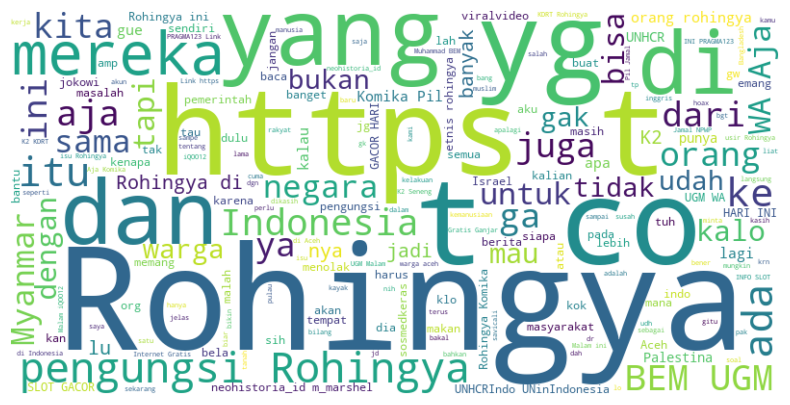

In [25]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
df.rename(columns={"full_text": "text"}, inplace=True)

In [28]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [30]:
def cleaningText(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # remove mentions
    text = re.sub(r"#[A-Za-z0-9]+", "", text)  # remove hashtag
    text = re.sub(r"RT[\s]", "", text)  # remove RT
    text = re.sub(r"http\S+", "", text)  # remove link
    text = re.sub(r"[0-9]+", "", text)  # remove numbers

    text = text.replace("\n", " ")  # replace new line into space
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # remove all punctuations
    text = text.strip(" ")  # remove characters space from both left and right text
    return text

def replaceEmojis(text):
    for emoji, meaning in emojis.items():
        text = text.replace(emoji, "EMOJI" + meaning)
    return text

def casefoldingText(text):  # Converting all the characters in a text into lower case
    text = text.lower()
    return text


def tokenizingText(
        text,
):  # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text


# Fungsi untuk memuat stopword dari file CSV
def load_stopwords(csv_filepath):
    df_stopwords = pd.read_csv(csv_filepath)
    return set(df_stopwords['ada'])  # Nama kolom dari stopword tersebut adalah "ada"

# Mengganti fungsi filteringText untuk menggunakan stopword dari file CSV
def filteringText(text, stopwords_set):
    filtered = [word for word in text if word not in stopwords_set]
    return filtered

# Jalur file ke stopword CSV (sesuaikan dengan lokasi file Anda)
csv_filepath = 'stopwordbahasa.csv'

# Memuat stopword dari file CSV
listStopwords = load_stopwords(csv_filepath)

def stemmingText(
        text,
):  # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text


def toSentence(list_words):  # Convert list of words into sentence
    sentence = " ".join(word for word in list_words)
    return sentence

In [31]:
# Preprocessing df data
df["text_clean"] = df["text"].apply(replaceEmojis)
df["text_clean"] = df["text"].apply(cleaningText)
df["text_clean"] = df["text_clean"].apply(casefoldingText)
df.drop(["text"], axis=1, inplace=True)

df["text_preprocessed"] = df["text_clean"].apply(tokenizingText)
df["text_preprocessed"] = df["text_preprocessed"].apply(lambda x: filteringText(x, listStopwords))
df["text_preprocessed"] = df["text_preprocessed"].apply(stemmingText)

# drop duplicates/spams data
df.drop_duplicates(subset="text_clean", inplace=True)

df.head()

,text_clean,text_preprocessed
0,nsyam id semoga aja rohingya ngikutin jejak ...,"[nsyam, id, moga, aja, rohingya, ngikutin, jej..."
1,sejarah kelam orde baru yg nampaknya terulang ...,"[sejarah, kelam, orde, yg, nampaknya, ulang, ,..."
2,rohingya itu lamalama bisa memberontak pada ne...,"[rohingya, lamalama, berontak, negara, indones..."
3,yg bayar itu karena kasus perdagangan manusia ...,"[yg, bayar, dagang, manusia, kena, tipu, tanah..."
4,terlepas akun fake atau apalah terkait rohingy...,"[lepas, akun, fake, apa, kait, rohingya, duduk..."


In [33]:
# Export to csv file
df.to_csv(
    r"merged_final.csv",
    index=False,
    header=True,
    index_label=None,
)

In [35]:
df.tail(10)

,text_clean,text_preprocessed
689,nihh di jabar kan yah kapal rohingya yg masuk ...,"[nihh, jabar, yah, kapal, rohingya, yg, masuk,..."
690,sesungguhnya pahendi kalo udah masang lagu ini...,"[sungguh, pahendi, kalo, udah, masang, lagu, y..."
691,ruang di tengah hiruk pikuk timeline dgn polit...,"[ruang, hiruk, pikuk, timeline, dgn, politik, ..."
692,rohingya guru มาแล้วคับจารย์ vanesya zayyan,"[rohingya, guru, , vanesya, zayyan]"
694,jng smp indonesia nt kaya palestina sama israe...,"[jng, smp, indonesia, nt, kaya, palestina, isr..."
695,udah di kasih gambaran kalo warga rohingya di ...,"[udah, kasih, gambar, kalo, warga, rohingya, t..."
697,baca sentimen hari ini soal etnis rohingya kok...,"[baca, sentimen, etnis, rohingya, rem, banget,..."
698,id marshel setuju lebih miris lagi aki aki di ...,"[id, marshel, tuju, miris, aki, aki, thn, oagi..."
699,wkwk lucuu emg bener ada ko diskusinya ya lah ...,"[wkwk, lucuu, emg, bener, ada, ko, diskusi, ya..."
700,mau demonisasi pengungsi rohingyakalo salah di...,"[demon, ungsi, rohingyakalo, salah, tegur, kri..."


In [20]:
df = pd.read_csv("data/merged_final.csv", delimiter=",")

df.tail()

,text_clean,text_preprocessed
668,udah di kasih gambaran kalo warga rohingya di ...,"['udah', 'kasih', 'gambar', 'kalo', 'warga', '..."
669,baca sentimen hari ini soal etnis rohingya kok...,"['baca', 'sentimen', 'etnis', 'rohingya', 'rem..."
670,id marshel setuju lebih miris lagi aki aki di ...,"['id', 'marshel', 'tuju', 'miris', 'aki', 'aki..."
671,wkwk lucuu emg bener ada ko diskusinya ya lah ...,"['wkwk', 'lucuu', 'emg', 'bener', 'ada', 'ko',..."
672,mau demonisasi pengungsi rohingyakalo salah di...,"['demon', 'ungsi', 'rohingyakalo', 'salah', 't..."


In [21]:
def preprocess_text(text):
    if pd.isna(text):
        return []
    text = str(text)
    cleaned_text = (
        text.replace("'", "").replace(",", "").replace("]", "").replace("[", "")
    )
    words_list = cleaned_text.split()
    return words_list


df["text_preprocessed"] = df["text_preprocessed"].apply(preprocess_text)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         673 non-null    object
 1   text_preprocessed  673 non-null    object
dtypes: object(2)
memory usage: 10.6+ KB


In [23]:
df['text_clean'] = df['text_clean'].fillna('')

In [24]:
all_text = " ".join(tweet for tweet in df["text_clean"])

wordcloud_preprocessed = WordCloud(
    background_color="white", width=800, height=400
).generate(all_text)

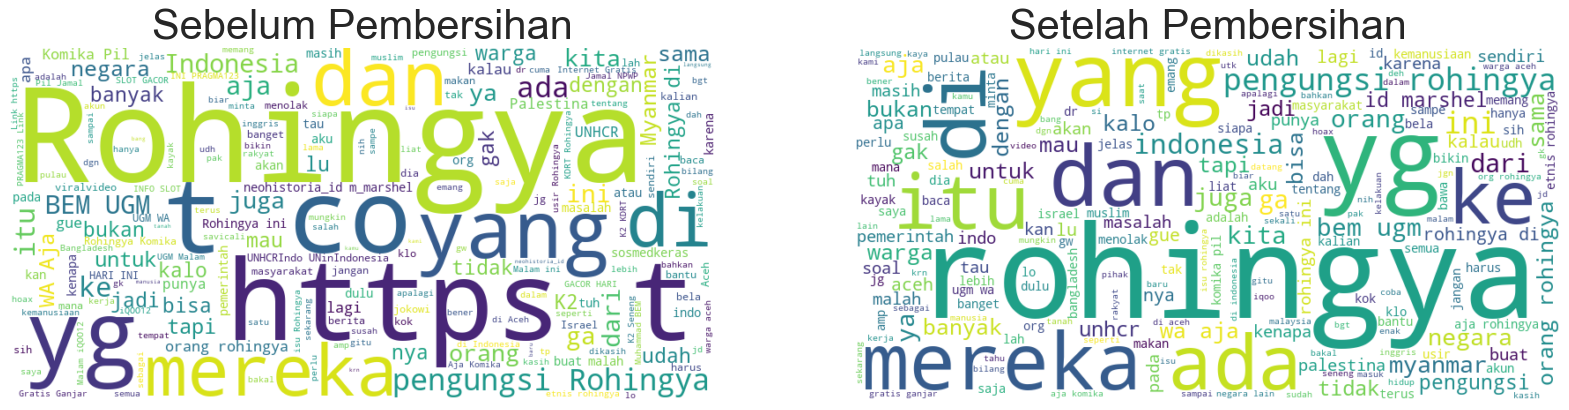

In [25]:
# Mengatur subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Tampilkan WordCloud sebelum pembersihan
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Sebelum Pembersihan", fontsize=30)

# Tampilkan WordCloud setelah pembersihan
ax2.imshow(wordcloud_preprocessed, interpolation="bilinear")
ax2.axis("off")
ax2.set_title("Setelah Pembersihan", fontsize=30)  # Mengubah ukuran font menjadi 20
# Tampilkan plot
plt.show()

In [26]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [27]:
df["text_len"] = text_len

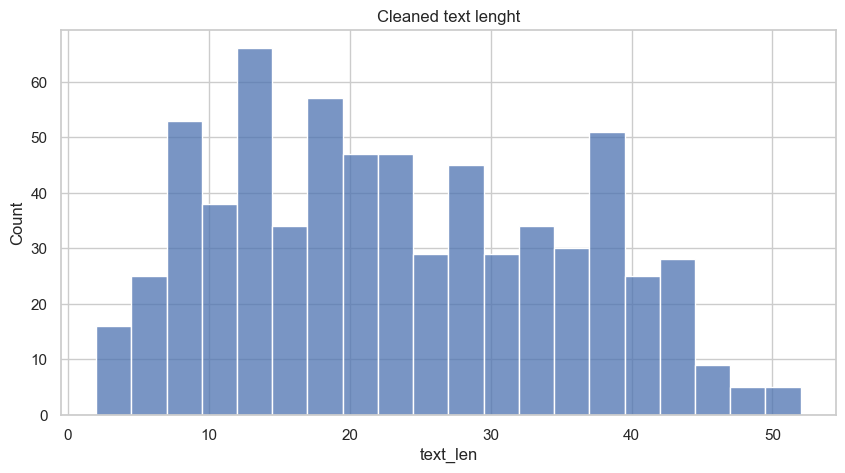

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(x="text_len", data=df, bins=20)
plt.title("Cleaned text lenght")
plt.show()

C:\Users\novin\AppData\Local\Temp\ipykernel_25348\3269793291.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="text_len", data=df[df["text_len"] < 10], palette="mako")


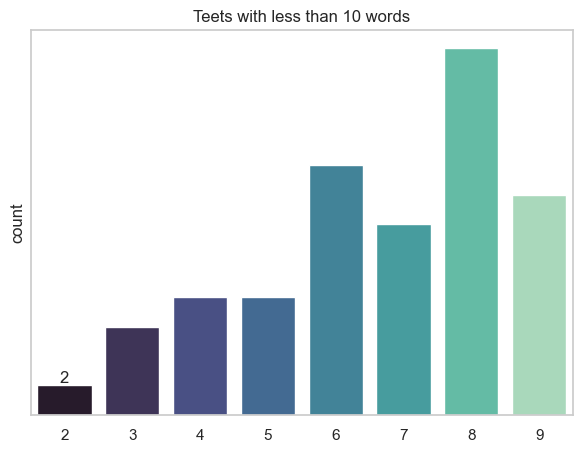

In [29]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x="text_len", data=df[df["text_len"] < 10], palette="mako")
plt.title("Teets with less than 10 words")
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel("count")
plt.xlabel("")
plt.show()

In [30]:
df = df[df["text_len"] > 4]

In [31]:
positive = pd.read_csv('lexicon/positive.tsv', delimiter="\t")

positive.head()

,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2


In [32]:
try:
    negative = pd.read_csv('lexicon/negative.tsv', delimiter="\t")
except UnicodeDecodeError:
    negative = pd.read_csv('lexicon/negative.tsv', delimiter="\t", encoding='latin1')  # atau 'ISO-8859-1', 'cp1252'

negative.head()

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5


In [33]:
import csv

lexicon_positive = dict()
with open("lexicon/positive.tsv", "r", encoding="ISO-8859-1") as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")
    header = next(reader, None)
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open("lexicon/negative.tsv", "r", encoding="ISO-8859-1") as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")
    header = next(reader, None)
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Function to determine sentiment polarity of df
def sentiment_analysis_lexicon_indonesia(text):
    # for word in text:
    score = 0
    for word in text:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]
    for word in text:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]
    polarity = ""
    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"
    return score, polarity

In [34]:
results = df["text_preprocessed"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]
print(df["polarity"].value_counts())

polarity
negative    389
positive    214
neutral      54
Name: count, dtype: int64


In [72]:
df.sample(10)

,text_clean,text_preprocessed,text_len,polarity_score,polarity
598,usir rohingya dr negeri ini 🤜,"[usir, rohingya, dr, negeri]",6,-4,negative
144,alhamdulillah sekarang banyak banget yang voka...,"[alhamdulillah, banget, vokal, rohingya, jujur...",28,9,positive
421,ekspresi ketika setelah di lamar kdm drakor ...,"[ekspresi, lamar, kdm, drakor, the, matchmaker...",23,-4,negative
127,kunjungi ikn ganjar tegaskan bakal lanjutkan💪🤟...,"[kunjung, ikn, ganjar, tegas, lanjut, bem, ugm...",18,-1,negative
341,skirt rok keren ✨😍 🍒 🍒 🍒,"[skirt, rok, keren]",7,0,neutral
151,id kembalikan pengungsi rohingya ke negara asa...,"[id, kembali, ungsi, rohingya, negara, asal, k...",24,-2,negative
419,kalau jangan khawatir duhai para fasilitas...,"[khawatir, duhai, fasilitas, tampung, ada, pas...",17,-4,negative
96,se warga aceh menolak kedatangan pengungsi roh...,"[warga, aceh, tolak, datang, ungsi, rohingya, ...",15,-7,negative
21,ganjar tuntaskan ikn bem ugm indro komika pil...,"[ganjar, tuntas, ikn, bem, ugm, indro, komika,...",14,4,positive
125,id marshel ini gimana dah kok tiba bawa jerma...,"[id, marshel, gimana, dah, bawa, jerman, invas...",37,-10,negative


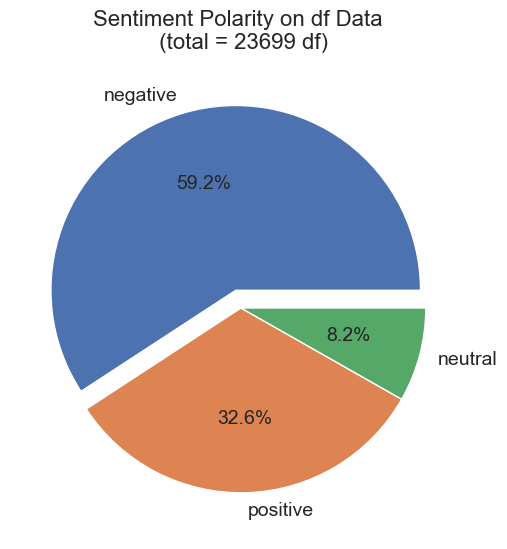

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.1f%%",
    explode=explode,
    textprops={"fontsize": 14},
)
ax.set_title("Sentiment Polarity on df Data \n (total = 23699 df)", fontsize=16, pad=20)
plt.show()

In [36]:
pd.set_option("display.max_colwidth", 3000)
positive_df = df[df["polarity"] == "positive"]
positive_df = (
    positive_df[["text_clean", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=False)
    .reset_index(drop=True)
)
positive_df.index += 1
positive_df[0:10]

,text_clean,polarity_score,polarity
1,welcome welcome kalian bukan binatang kalian muslim saudara kami allah yg kasih rezeki bukan kalian etnis rohingya,20,positive
2,yang namanya orang bisa berkembang bro israel juga awalnya pengungsi lama lama berkembang jadi negara maju sekarang yang disokong amrik maksud gue jangan sampe negara lain memanfaatkan rohingya buat sabotase indonesia heran gue masih ada aja yang bela rohingya,19,positive
3,yang muslim amp mukmin harusnya belain rohingya mereka pindah biar bisa ibadah dengan tenang itu adalah kewajiban untuk membantu sesama muslim yang ingin melaksanakan ibadah dengan tenang di alquran kita diwajibkan untuk memberi mereka perlindungan,18,positive
4,pasangan cerdas jadi seneng liatnya bagaimana memang saling support demi kemajuan📈 bem ugm the k rohingya wa aja komika seneng muhammad pil,18,positive
5,wkwk lucuu emg bener ada ko diskusinya ya lah media skrg kan yg di framing sasarannya cm gibran🙄 coba kl gibran yg ngomong udh pasti di bkin headline “gibran sambut dan dukung rohingya”,14,positive
6,testimoni para pasien kami terima kasih telah mempercayakan perawatan kesehatan dan pengobatan penyakit dengan kami semoga sehat selalu nggih 🙏 wa aja muhammad rohingya,13,positive
7,warga dukunt ganjar mahfud bem ugm wa aja komika pil the k seneng rohingya muhammad jungkook pil internet gratis ganjar cat,13,positive
8,aneka resep makanan yang enak dari kikil bem ugm wa aja komika kdrohingya npwp seneng the k myanmar,12,positive
9,rohingya adalah israel beda ya israel ngungsi ke tanah palestina itu udah dapet sponsor dari inggris lewat balfour declaration rohingya ngungsi ke luar myanmar disponsori ama penyelundup dan malaikat maut,12,positive
10,unhcr wa aja rohingya seneng bangladesh muhammad cat pradareporter x win internet gratis ganjar 👇💦💦kacamata sipit versi android versi apple ios,11,positive


In [37]:
pd.set_option("display.max_colwidth", 3000)
negative_tweets = df[df["polarity"] == "negative"]
negative_tweets = (
    negative_tweets[["text_clean", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=True)[0:10]
    .reset_index(drop=True)
)
negative_tweets.index += 1
negative_tweets[0:20]

,text_clean,polarity_score,polarity
1,ini yg lagi viral kakak adek ngen brutal sampai nangis 😱 link di komentar pelajar bokep indo viral terbaru vcs vidio indonesia colmek scandal bumil jilbab mesum bahan coli hijab memek basah tante sange selebgram aceh rohingya aaaaaaaaaa aaaaaaaaaah,-35,negative
2,apa masyarakat kita pada terancam nyawanya krna kelaparan di rohingya sana orang dibunuhi lho mba bukan kabur krna pengen pindah ke indo dah ah males ngeyel bebal leave aja byeee,-32,negative
3,id marshel persentase yang itu untuk apa mewajarkan hal yang salah rohingya bukan penjajah ini mungkin benar tapi juga bisa dibantah karena masih simpang siur tapi apa salahnya menganggap orang yg maksa masuk negara sbg penjajah precaution lho,-32,negative
4,viral dukun sang perkosa pasiennya sampe pingsan🥵 link full komentarbio profil pelajar bokep indo viral terbaru ginting colmek scandal mesum bahan coli memek basah tidur arhan israel pasumi malam minggu wa aja rohingya bem ugm aaaaaaaaaah,-29,negative
5,ah susah mbak ngajarnya ke masyarakat kita salah terus yg diprotesnya karena gak paham isreal yg nyerang yg disalahin semua org yahudi ada satu warga rohingya yg berbuat buruk semuanya ditolak kkb bunuh seseorang semua pen papua dibilang jahat,-29,negative
6,com bedakan pengungsi rohingya original ga membayar makelar jml dan kapalnya random ga tau jml temannya yg lain sering kelaparan krn ga ada makanan diburu sampai ke laut ga ada yg membuang makanan yg diberi ga mengeluh kurang makanan yg dibagi analisanya bro,-28,negative
7,wih si iq paling tinggi abis ngatain orang iq jongkok trus ngomong ga peduli meluruskan tapi ngatain orang malas pengen kek rohingya iq jongkok wiih mending lu coba tampung rohingya ntar gausah ribet mikir makanan mereka ada pbb yg ngurus kalo udah baru boleh bacot,-26,negative
8,id marshel sorry nih emangnya segampang itu kita orng luar mau berusaha menghentikan genosida amp pengusiran kita juga ga akan sekejam itu nolak warga rohingya klo merekanya pun ngaa macem mereka nih banyak yg meresahkan wajar kita harus waspada kalo terus²an dikasihani ngelunjak ntar,-26,negative
9,warga aceh jgn kalian salah di dalam mengartikan saudara seiman dgn rohingya kalain saja yg saudara kandung masih banyak yg susah susah tempat tinggal susah makan kasi makan kasi bekal naikan di kapal dorong ke laut lepas lupakan unhcr apakah unhcr tahu dgn kalian yg susah,-26,negative
10,mereka udah dapat pulau di bangladesh mereka ilegal masuk ke negara org lain jelas melanggar hukum indo tidak mendatangi perjanjian pengungsi mereka beban karna jadi beban itu melanggar hak org wes ndang muliho wes surup iki drpada diamuk,-25,negative


In [38]:
# Results from determine sentiment polarity of df

results = df["text_preprocessed"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]
print(df["polarity"].value_counts())

# Export to csv file
df.to_csv(
    "polarity.csv",
    index=False,
    header=True,
    index_label=None,
)

df.head(10)

polarity
negative    389
positive    214
neutral      54
Name: count, dtype: int64


,text_clean,text_preprocessed,text_len,polarity_score,polarity
0,nsyam id semoga aja rohingya ngikutin jejak israel kelakbiar israel tdk sendirian dihujat,"[nsyam, id, moga, aja, rohingya, ngikutin, jejak, israel, kelakbiar, israel, tdk, hujat]",13,-5,negative
1,sejarah kelam orde baru yg nampaknya terulang 🤔 jgn lagilagi deh komika bem ugm pil pil wa aja malaysia rohingya myanmar muhammad kdaceh,"[sejarah, kelam, orde, yg, nampaknya, ulang, jgn, lagilagi, deh, komika, bem, ugm, pil, pil, wa, aja, malaysia, rohingya, myanmar, muhammad, kdaceh]",23,0,neutral
2,rohingya itu lamalama bisa memberontak pada negara indonesia yang danainya mamarica loh,"[rohingya, lamalama, berontak, negara, indonesia, dana, mamarica, loh]",12,4,positive
3,yg bayar itu karena kasus perdagangan manusia mereka kena tipu dan soal minta tanah di malay itu hoax karena itu penggalan video saat warga rohingya demonstrasi menuntut dihentikannya genosida,"[yg, bayar, dagang, manusia, kena, tipu, tanah, malay, hoax, penggal, video, warga, rohingya, demonstrasi, tuntut, henti, genosida]",29,-17,negative
4,terlepas akun fake atau apalah terkait rohingya seharusnya juga mendudukan pihak myanmar karena akar masalah rohingya itu kan dengan myanmar indonesia itu hanya penampungan sementara tapi namanya sementara itu ada waktunya ya tidak sementara yg berkepanjangan,"[lepas, akun, fake, apa, kait, rohingya, duduk, myanmar, akar, rohingya, myanmar, indonesia, tampung, nama, ada, ya, yg, panjang]",36,2,positive
5,gajadi tamat malem ini gue baru sampe kost habis diskusi tentang pilpres rohingya jodoh dll mungkin besok,"[gajadi, tamat, malem, gue, sampe, kost, habis, diskusi, pilpres, rohingya, jodoh, dll, besok]",17,-5,negative
6,wowo gobel naik jabatan sedangkan kasusnya belum selesai apalagi dia adalah makhluk pelanggar ham wa aja bem ugm kdrohingya npwp seneng muhammad cakep banget tonton 👇,"[wowo, gobel, jabat, kasus, selesai, makhluk, langgar, ham, wa, aja, bem, ugm, kdrohingya, npwp, neng, muhammad, cakep, banget, tonton]",26,4,positive
7,id marshel sorry nih emangnya segampang itu kita orng luar mau berusaha menghentikan genosida amp pengusiran kita juga ga akan sekejam itu nolak warga rohingya klo merekanya pun ngaa macem mereka nih banyak yg meresahkan wajar kita harus waspada kalo terus²an dikasihani ngelunjak ntar,"[id, marshel, sorry, nih, emang, gampang, orng, usaha, henti, genosida, amp, usir, ga, kejam, nolak, warga, rohingya, klo, mereka, ngaa, macem, nih, yg, resah, wajar, waspada, kalo, terus, an, kasihan, ngelunjak, ntar]",44,-26,negative
8,lupa pancasila bem ugm wa aja komika pil the k seneng rohingya muhammad jungkook pil internet gratis ganjar cat,"[lupa, pancasila, bem, ugm, wa, aja, komika, pil, the, k, neng, rohingya, muhammad, jungkook, pil, internet, gratis, ganjar, cat]",19,9,positive
9,ganjar tegaskan bakal lanjutkan pembangunan ikn💪 indro malam bem ugm komika pil the k muhammad the un security council rohingya myanmar hunter biden pil nayeon ozil pil npwp,"[ganjar, tegas, lanjut, bangun, ikn, indro, malam, bem, ugm, komika, pil, the, k, muhammad, the, un, security, council, rohingya, myanmar, hunter, biden, pil, nayeon, ozil, pil, npwp]",28,-2,negative


In [39]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words = []
    negative_words = []
    for word in text:
        score_pos = 0
        score_neg = 0
        if word in lexicon_positive:
            score_pos = lexicon_positive[word]
        if word in lexicon_negative:
            score_neg = lexicon_negative[word]

        if score_pos + score_neg > 0:
            positive_words.append(word)
        elif score_pos + score_neg < 0:
            negative_words.append(word)

    return positive_words, negative_words

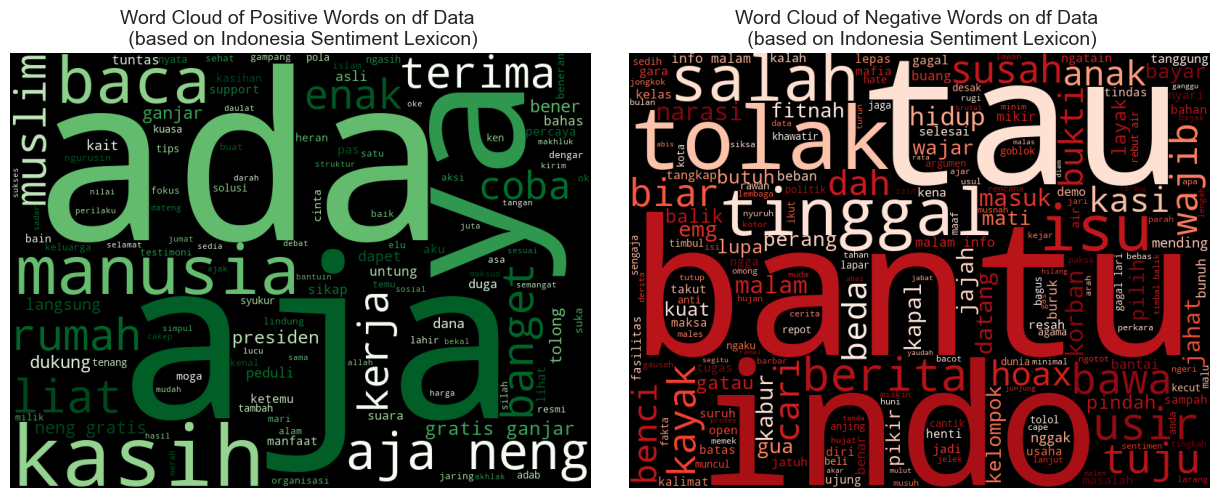

In [40]:
# Visualize positive and negative word cloud

sentiment_words = df["text_preprocessed"].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 10))
list_words_postive = ""
for row_word in positive_words:
    for word in row_word:
        list_words_postive += " " + (word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_words_postive)
ax[0].set_title(
    "Word Cloud of Positive Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

list_words_negative = ""
for row_word in negative_words:
    for word in row_word:
        list_words_negative += " " + (word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_words_negative)
ax[1].set_title(
    "Word Cloud of Negative Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

In [41]:
from nltk import WordNetLemmatizer


def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [42]:
dataframe = df.copy()

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 657 entries, 0 to 672
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         657 non-null    object
 1   text_preprocessed  657 non-null    object
 2   text_len           657 non-null    int64 
 3   polarity_score     657 non-null    int64 
 4   polarity           657 non-null    object
dtypes: int64(2), object(3)
memory usage: 30.8+ KB


In [43]:
kolom_yang_dihapus = [
    "text_preprocessed",
    "text_len",
    "polarity_score"
]


dataframe = dataframe.drop(kolom_yang_dihapus, axis=1)

In [44]:
text, sentiment = list(dataframe['text_clean']), list(dataframe['polarity'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  14945


In [47]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [48]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [88]:
results = None

try:
    BNBmodel = BernoulliNB(alpha = 2)
    BNBmodel.fit(X_train, y_train)
    y_pred = BNBmodel.predict(X_test)
    results = classification_report(y_test, y_pred)
except Exception as e:
    print(f"An error occurred during model fitting or evaluation: {e}")
finally:
    if results is not None:
        print("Model Evaluation Results:")
        print(results)
    else:
        print("No results to display.")

Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80        22
     neutral       0.00      0.00      0.00         3
    positive       0.00      0.00      0.00         8

    accuracy                           0.67        33
   macro avg       0.22      0.33      0.27        33
weighted avg       0.44      0.67      0.53        33


C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [89]:
results_svc = None

try:
    SVCmodel = LinearSVC()
    SVCmodel.fit(X_train, y_train)
    y_pred_svc = SVCmodel.predict(X_test)
    results_svc = classification_report(y_test, y_pred_svc)
except Exception as e:
    print(f"An error occurred during LinearSVC fitting or evaluation: {e}")
finally:
    if results_svc is not None:
        print("LinearSVC Model Evaluation Results:")
        print(results_svc)
    else:
        print("No results to display for LinearSVC.")


LinearSVC Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.81      0.95      0.88        22
     neutral       0.50      0.33      0.40         3
    positive       0.80      0.50      0.62         8

    accuracy                           0.79        33
   macro avg       0.70      0.60      0.63        33
weighted avg       0.78      0.79      0.77        33


C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [50]:
from sklearn.naive_bayes import MultinomialNB

results_nb = None

try:
    NB_model = MultinomialNB()
    NB_model.fit(X_train, y_train)
    y_pred_nb = NB_model.predict(X_test)
    results_nb = classification_report(y_test, y_pred_nb)
except Exception as e:
    print(f"An error occurred during Naive Bayes fitting or evaluation: {e}")
finally:
    if results_nb is not None:
        print("Naive Bayes Model Evaluation Results:")
        print(results_nb)
    else:
        print("No results to display for Naive Bayes.")

Naive Bayes Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.70      0.95      0.81        22
     neutral       0.00      0.00      0.00         3
    positive       0.67      0.25      0.36         8

    accuracy                           0.70        33
   macro avg       0.46      0.40      0.39        33
weighted avg       0.63      0.70      0.63        33


C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\novin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [51]:
from sklearn.ensemble import RandomForestClassifier

results_rf = None

try:
    RF_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Jumlah pohon dapat disesuaikan
    RF_model.fit(X_train, y_train)
    y_pred_rf = RF_model.predict(X_test)
    results_rf = classification_report(y_test, y_pred_rf)
except Exception as e:
    print(f"An error occurred during Random Forest fitting or evaluation: {e}")
finally:
    if results_rf is not None:
        print("Random Forest Model Evaluation Results:")
        print(results_rf)
    else:
        print("No results to display for Random Forest.")

Random Forest Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.71      0.91      0.80        22
     neutral       0.50      0.33      0.40         3
    positive       0.33      0.12      0.18         8

    accuracy                           0.67        33
   macro avg       0.52      0.46      0.46        33
weighted avg       0.60      0.67      0.61        33


In [49]:
from sklearn.svm import SVC

results_svm = None

try:
    SVM_model = SVC(kernel='linear')  # Pilih kernel yang sesuai, contohnya linear atau rbf
    SVM_model.fit(X_train, y_train)
    y_pred_svm = SVM_model.predict(X_test)
    results_svm = classification_report(y_test, y_pred_svm)
except Exception as e:
    print(f"An error occurred during SVM fitting or evaluation: {e}")
finally:
    if results_svm is not None:
        print("SVM Model Evaluation Results:")
        print(results_svm)
    else:
        print("No results to display for SVM.")

SVM Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.75      0.95      0.84        22
     neutral       0.50      0.33      0.40         3
    positive       0.67      0.25      0.36         8

    accuracy                           0.73        33
   macro avg       0.64      0.51      0.53        33
weighted avg       0.71      0.73      0.68        33


In [90]:
results_lr = None

try:
    LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
    LRmodel.fit(X_train, y_train)
    y_pred_lr = LRmodel.predict(X_test)
    results_lr = classification_report(y_test, y_pred_lr)
except Exception as e:
    print(f"An error occurred during LogisticRegression fitting or evaluation: {e}")
finally:
    if results_lr is not None:
        print("LogisticRegression Model Evaluation Results:")
        print(results_lr)
    else:
        print("No results to display for LogisticRegression.")


LogisticRegression Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.78      0.95      0.86        22
     neutral       0.50      0.33      0.40         3
    positive       0.75      0.38      0.50         8

    accuracy                           0.76        33
   macro avg       0.68      0.55      0.59        33
weighted avg       0.75      0.76      0.73        33


In [92]:
import pickle

file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [97]:
csv_filepath = 'stopwordbahasa.csv'

In [98]:
def load_stopwords(csv_filepath):
    """
    Load stopwords from a CSV file.
    """
    df_stopwords = pd.read_csv(csv_filepath)
    # Assuming the file has one column with the name 'stopword'
    return set(df_stopwords['ada'].tolist())

In [100]:
def preprocess(text, csv_filepath):
    """
    Preprocess the input text: clean, case fold, tokenize, remove stopwords, and stem.
    """
    # Load stopwords from CSV
    stopwords_set = load_stopwords(csv_filepath)

    text = cleaningText(text)
    text = casefoldingText(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens, stopwords_set)
    tokens = stemmingText(tokens)
    return ' '.join(tokens)  # Rejoin tokens into a single string

# Example usage
sample_text = "tolak rohingya di indonesia"
processed_text = preprocess(sample_text, csv_filepath)
print(processed_text)

tolak rohingya indonesia


In [102]:
def load_model(filepath):
    """
    Load a model from the specified file path.
    """
    with open(filepath, 'rb') as file:
        return pickle.load(file)

In [104]:
vectoriser = load_model('vectoriser-ngram-(1,2).pickle')
LRmodel = load_model('Sentiment-LR.pickle')

# Preprocess teks yang akan diprediksi
texts = ["tolak pengungsi rohingya, masyarakat masih banyak yang butuh atensi pemerintah, banyak yang kekurangan"]
processed_texts = [preprocess(text, csv_filepath) for text in texts]
vectorised_texts = vectoriser.transform(processed_texts)

# Lakukan prediksi
predictions = LRmodel.predict(vectorised_texts)

# Tampilkan hasil
for text, pred in zip(texts, predictions):
    print(f"Text: {text}, Prediction: {pred}")

Text: tolak pengungsi rohingya, masyarakat masih banyak yang butuh atensi pemerintah, banyak yang kekurangan, Prediction: negative


In [106]:
new_texts = ["tolak pengungsi rohingya, masyarakat masih banyak yang butuh atensi pemerintah, banyak yang kekurangan"]

# Preprocess the new texts
processed_new_texts = [preprocess(text, csv_filepath) for text in new_texts]
vectorised_new_texts = vectoriser.transform(processed_new_texts)

# Perform predictions on the new texts
new_predictions = LRmodel.predict(vectorised_new_texts)

# Display the results for the new texts
for text, pred in zip(new_texts, new_predictions):
    print(f"Text: {text}, Prediction: {pred}")


Text: tolak pengungsi rohingya, masyarakat masih banyak yang butuh atensi pemerintah, banyak yang kekurangan, Prediction: negative
